# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
def compute_rank_mapping(archive_name):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = json.loads(zipfile.ZipFile(archive_name).read('history.json'))
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    assert len(mpirun) == 1
    mpirun = mpirun[0]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df

In [3]:
directory = 'dgemm_prediction/1'
archives = [os.path.join(directory, filename) for filename in os.listdir(directory)]

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace %s: %6d lines' % (archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df



traces = [read_archive(filename, 0) for filename in archives]
traces = pandas.concat(traces)

traces = traces[traces['function'] == 'dgemm']
traces.head()

Read trace dgemm_prediction/1/grenoble_2019-07-22_1876045.zip: 3708784 lines
Read trace dgemm_prediction/1/grenoble_2019-07-22_1876043.zip: 3722055 lines
Read trace dgemm_prediction/1/grenoble_2019-07-22_1876042.zip: 3770526 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,hostname,socket,core,node,cpu
1,0,1876045,dgemm,0.331788,0.331822,4734.0,2.0,2.0,0.000034,1,dahu-1.grenoble.grid5000.fr,0,0,1,0
2,0,1876045,dgemm,0.331935,0.331976,4732.0,4.0,4.0,0.000042,1,dahu-1.grenoble.grid5000.fr,0,0,1,0
3,0,1876045,dgemm,0.332043,0.332058,4730.0,2.0,2.0,0.000015,1,dahu-1.grenoble.grid5000.fr,0,0,1,0
4,0,1876045,dgemm,0.332123,0.332205,4728.0,8.0,8.0,0.000082,1,dahu-1.grenoble.grid5000.fr,0,0,1,0
5,0,1876045,dgemm,0.332272,0.332287,4726.0,2.0,2.0,0.000015,1,dahu-1.grenoble.grid5000.fr,0,0,1,0


In [4]:
traces[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1876042,dahu-9.grenoble.grid5000.fr,9
1,1876042,dahu-10.grenoble.grid5000.fr,10
2,1876042,dahu-11.grenoble.grid5000.fr,11
3,1876042,dahu-12.grenoble.grid5000.fr,12
4,1876042,dahu-13.grenoble.grid5000.fr,13
5,1876042,dahu-14.grenoble.grid5000.fr,14
6,1876042,dahu-15.grenoble.grid5000.fr,15
7,1876042,dahu-16.grenoble.grid5000.fr,16
8,1876043,dahu-17.grenoble.grid5000.fr,17
9,1876043,dahu-18.grenoble.grid5000.fr,18


## HPL result

In [5]:
res = pandas.concat([read_csv(filename, 'results.csv') for filename in archives])
res[['jobid', 'matrix_size', 'time']].sort_values(by='matrix_size')

,jobid,matrix_size,time
0,1876045,150000,399.76
0,1876043,150000,389.92
0,1876042,150000,394.97


## Checking the parameters

In [6]:
pandas.concat([read_csv(filename, 'exp_small.csv') for filename in archives])

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,150000,128,32,8,1,2,2,1,0,8,32,1,1876045
0,150000,128,32,8,1,2,2,1,0,8,32,1,1876043
0,150000,128,32,8,1,2,2,1,0,8,32,1,1876042


## Prediction error on the duration

In [7]:
stat_file = '/tmp/stats.csv'
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O {stat_file}
stats = pandas.read_csv(stat_file)
min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 4)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 5)))
stats = stats[(stats['start_time'] > min_epoch) & (stats['start_time'] < max_epoch) & (stats['cluster'] == 'dahu')]
stats['cpu'] = stats['node']*2 + stats['cpu'] - 2
print(len(stats))
stats.head()

--2019-07-23 14:33:03--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr… 134.158.69.41
Connexion à gitlab.in2p3.fr|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1736132 (1,7M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]   1,66M  --.-KB/s    ds 0,06s   

2019-07-23 14:33:03 (26,9 MB/s) — « /tmp/stats.csv » sauvegardé [1736132/1736132]

64


,function,cluster,node,cpu,jobid,start_time,expfile_hash,avg_gflops,intercept,intercept_residual,...,nk,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual
906,dgemm,dahu,8,14,1872794,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.411034,0.000002,2.663016e-07,...,3.090713e-09,3.021082e-12,54.476653,4.088793,5.882608,1.158967,803.873722,28.583488,90.088043,0.536700
907,dgemm,dahu,8,15,1872794,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.937655,0.000002,2.998226e-07,...,3.130368e-09,2.692329e-11,64.537640,7.550601,6.691685,1.514226,980.436894,15.627361,113.322230,9.122559
908,dgemm,dahu,9,16,1872795,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.869229,0.000002,3.490054e-07,...,3.091349e-09,3.335459e-11,65.893017,8.494052,6.804481,0.799481,1000.791409,15.193153,113.893371,11.086900
909,dgemm,dahu,9,17,1872795,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.936732,0.000002,3.180082e-07,...,3.084816e-09,2.859961e-11,65.921716,9.661060,6.792235,1.376712,1006.443702,23.944741,114.536584,14.429766
910,dgemm,dahu,1,0,1872787,1562253701,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,28.005161,0.000002,3.568280e-07,...,3.059798e-09,5.660122e-11,52.537827,1.342221,5.083726,0.406870,779.574051,19.143585,82.109109,6.597297


In [8]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    reg = stats[stats['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    traces.loc[traces['cpu'] == cpu, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[traces['cpu'] == cpu, 'pred'] += reg[prod] * traces[traces['cpu'] == cpu][prod]

In [9]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()
tmp = traces[(traces['abs_error'] > 0.1) & (traces['duration'] > 0.1)].sort_values(by='abs_error', axis=0, ascending=False)
print(len(tmp))
tmp.head()

32777


,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,core,node,cpu,pred,mnk,mn,mk,nk,error,abs_error
2679567,184,1876045,dgemm,365.0356,365.166941,1792.0,6912.0,128.0,0.131341,185,...,24,6,11,0.103275,1.585447e+09,12386304.0,229376.0,884736.0,-0.213689,0.213689
3301705,223,1876042,dgemm,361.9833,362.127266,1792.0,7552.0,128.0,0.143966,224,...,31,15,29,0.113298,1.732248e+09,13533184.0,229376.0,966656.0,-0.213020,0.213020
3497967,240,1876043,dgemm,362.3274,362.447637,1664.0,6784.0,128.0,0.120237,241,...,16,24,47,0.094699,1.444938e+09,11288576.0,212992.0,868352.0,-0.212396,0.212396
3614618,249,1876045,dgemm,361.3972,361.558394,1920.0,7936.0,128.0,0.161194,250,...,25,8,15,0.127302,1.950351e+09,15237120.0,245760.0,1015808.0,-0.210255,0.210255
2815524,193,1876043,dgemm,363.8195,363.933289,1664.0,6400.0,128.0,0.113789,194,...,1,23,44,0.089874,1.363149e+09,10649600.0,212992.0,819200.0,-0.210170,0.210170


In [10]:
melted = tmp.melt(id_vars=['jobid', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')

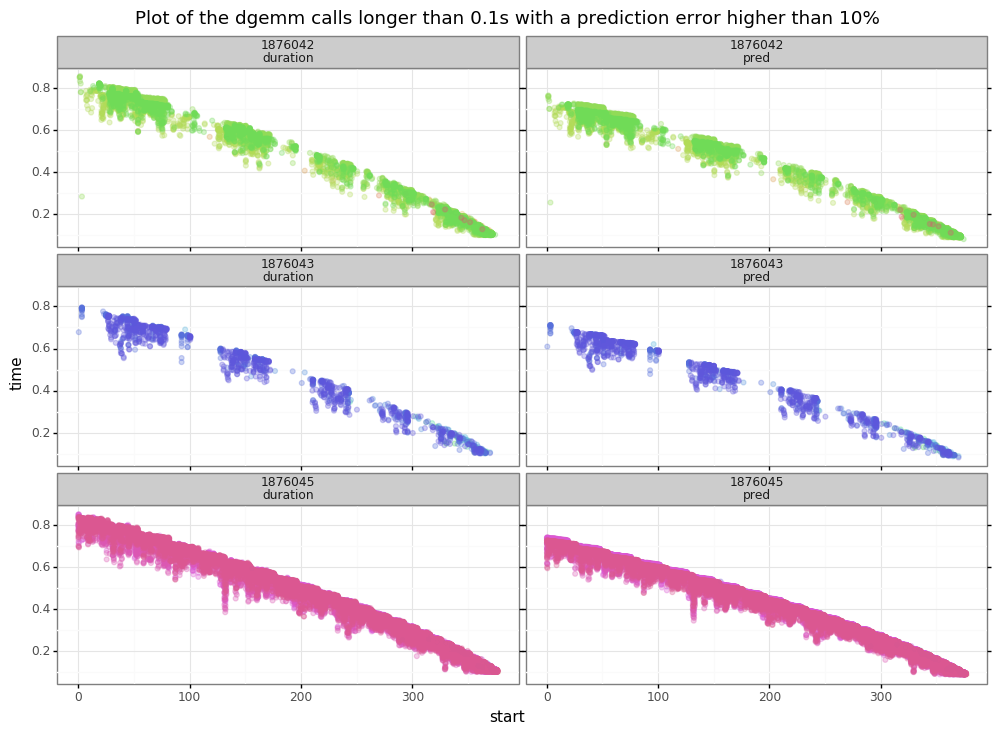

<ggplot: (8776010685725)>


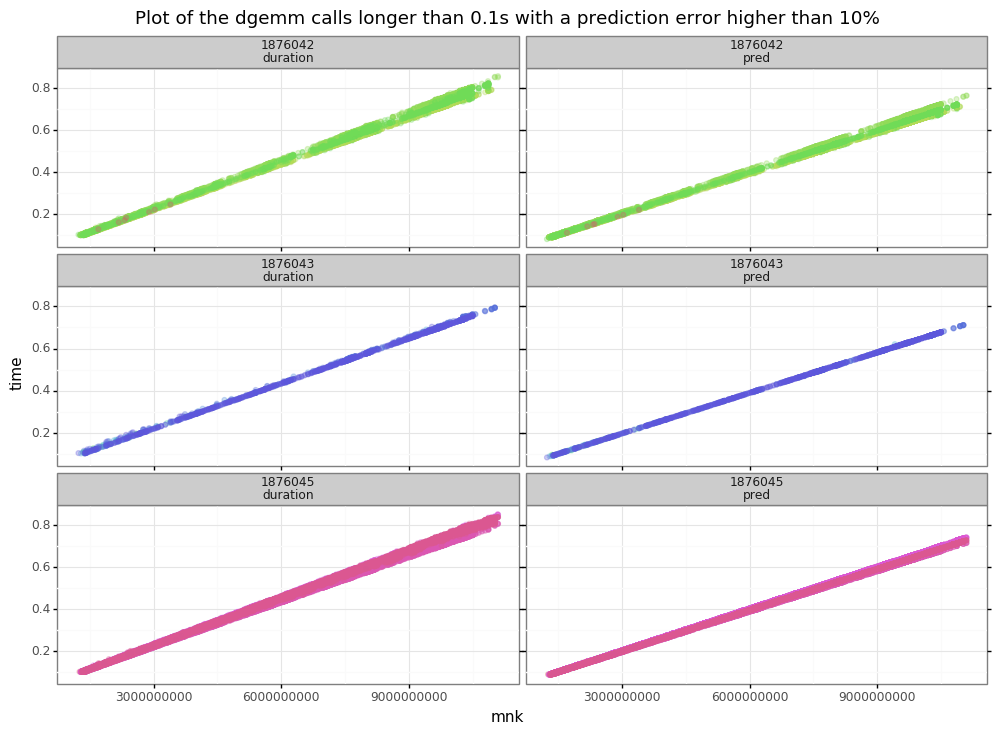

<ggplot: (-9223363260868549709)>


In [11]:
p = ggplot(melted, aes(y='time', color='factor(hostname)')) + theme_bw() + facet_wrap(['jobid', 'kind'], ncol=2)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
print(p + geom_point(aes(x='start'), alpha=0.3))
print(p + geom_point(aes(x='mnk'),   alpha=0.3))

In [12]:
summary = traces.groupby(['hostname', 'socket', 'cpu'])[['duration', 'pred']].sum().reset_index()
summary['error'] = (summary['pred'] - summary['duration']) / summary['duration']
summary['abs_error'] = summary['error'].abs()
summary.sort_values(by='abs_error', ascending=False)

,hostname,socket,cpu,duration,pred,error,abs_error
44,dahu-8.grenoble.grid5000.fr,0,14,5261.005769,4623.088194,-0.121254,0.121254
40,dahu-6.grenoble.grid5000.fr,0,10,5248.803851,4658.622493,-0.112441,0.112441
42,dahu-7.grenoble.grid5000.fr,0,12,4981.565019,4524.600905,-0.091731,0.091731
10,dahu-14.grenoble.grid5000.fr,0,26,5001.960276,4553.746744,-0.089608,0.089608
14,dahu-16.grenoble.grid5000.fr,0,30,5150.597694,4690.181464,-0.089391,0.089391
12,dahu-15.grenoble.grid5000.fr,0,28,5303.657417,4838.515667,-0.087702,0.087702
30,dahu-23.grenoble.grid5000.fr,0,44,4955.434229,4538.644988,-0.084108,0.084108
32,dahu-24.grenoble.grid5000.fr,0,46,4973.048181,4561.373594,-0.082781,0.082781
11,dahu-14.grenoble.grid5000.fr,1,27,4860.240812,4509.884532,-0.072086,0.072086
29,dahu-22.grenoble.grid5000.fr,1,43,4890.478176,4542.926780,-0.071067,0.071067
